# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin - final notebook for programming project 2

**IMPORTANT**: This notebook uses Python 3.

# Step 1: Load and split MNIST dataset

Load MNIST dataset in a sklearn-friendly format (from A. Géron's book).

In [38]:
# Adapted from Géron's notebooks 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import os
import numpy as np

# sklearn imports
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Standard library
import random

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

Split the dataset into training and test data and shuffle the training data to help classifiers that can get stuck a local minimum.

**IMPORTANT**: In the code below we are using the first 50,000 elements as the train set to match Nielsen's code. If we train with all 60,000 elements we would be giving this classifier an unfair edge over Nielsen's classifiers tested above.

Before we slice the 50,000 elements we need to shuffle the complete train set we get from MNIST. Otherwise we will not be sure we are getting the correct distribution for all digits (shuffling doesn't guarantee that either - we will check with a histogram below).

The test data is still the last 10,000 elements, as defined in the MNIST dataset. We currently don't use the elements in the [50,001-60,000] range. They would be used as a validation set.


In [3]:
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle the complete train set
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Now extract the first 50,000
X_train, y_train = X_train[:50000], y_train[:50000]

Check that we have a good distribution for all digits.

What we are looking for: about the same distribution of digits in the train and test set.

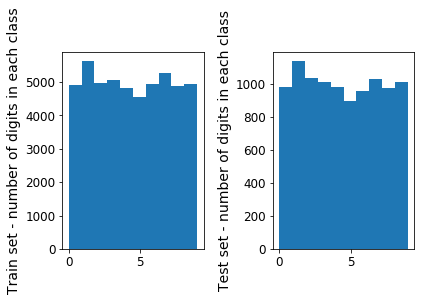

In [4]:
plt.subplot(121); plt.hist(y_train); plt.ylabel('Train set - number of digits in each class')
plt.subplot(122); plt.hist(y_test); plt.ylabel('Test set - number of digits in each class')
plt.tight_layout()
plt.show()

## Step 2: Baseline network

The "modernized" network from the experimental notebook was chosen as the final network for the report.

Although other networks came close to that performance, training the "modernized" network was significantly faster, making it more suitable for experiments.

**NOTE:** in all tests below we will use `random_state` to help the results more reproducible.

In [5]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", alpha=0.0001, 
                    batch_size=100, max_iter=30, verbose=True, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

Iteration 1, loss = 2.11388013
Iteration 2, loss = 0.54740304
Iteration 3, loss = 0.35945722
Iteration 4, loss = 0.26020279
Iteration 5, loss = 0.22002940
Iteration 6, loss = 0.19671125
Iteration 7, loss = 0.18037742
Iteration 8, loss = 0.17261197
Iteration 9, loss = 0.16232108
Iteration 10, loss = 0.15408800
Iteration 11, loss = 0.14582561
Iteration 12, loss = 0.14510094
Iteration 13, loss = 0.13350809
Iteration 14, loss = 0.13047489
Iteration 15, loss = 0.12153839
Iteration 16, loss = 0.11321633
Iteration 17, loss = 0.12047030
Iteration 18, loss = 0.11035314
Iteration 19, loss = 0.10294990
Iteration 20, loss = 0.10579903
Iteration 21, loss = 0.09384150
Iteration 22, loss = 0.09354898
Iteration 23, loss = 0.10036548
Iteration 24, loss = 0.09010691
Iteration 25, loss = 0.08670430
Iteration 26, loss = 0.08373755
Iteration 27, loss = 0.08919913
Iteration 28, loss = 0.08511802
Iteration 29, loss = 0.07394984
Iteration 30, loss = 0.07292516
MLPClassifier(activation='relu', alpha=0.0001, ba

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [6]:
#Evaluate accuracy on test set
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9583

# Step 3: Learning rate optimization

Since sklearn is reporting that the network is not converging after 30 iterations, we will first attempt to make it converge faster by increasing the learning rate.

## Step 3a: 10x learning rate

In [7]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate_init=0.01,  # <----- this is new
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, max_iter=30, verbose=True, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

Iteration 1, loss = 1.42456752
Iteration 2, loss = 0.78877301
Iteration 3, loss = 0.78630291
Iteration 4, loss = 0.79486998
Iteration 5, loss = 0.96504118
Iteration 6, loss = 1.04102825
Iteration 7, loss = 1.01567517
Iteration 8, loss = 1.12277052
Iteration 9, loss = 1.22886966
Iteration 10, loss = 1.14277430
Iteration 11, loss = 1.33065243
Iteration 12, loss = 1.27737751
Iteration 13, loss = 1.31323060
Iteration 14, loss = 1.31421521
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)
CPU times: user 52.6 s, 

In [8]:
#Evaluate accuracy on test set
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5129

A bit much...

## Step 3b: 5x learning rate

In [9]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate_init=0.005,  # <----- this has changed
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, max_iter=30, verbose=True, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

Iteration 1, loss = 1.26608104
Iteration 2, loss = 0.46026811
Iteration 3, loss = 0.40010692
Iteration 4, loss = 0.37725832
Iteration 5, loss = 0.38703815
Iteration 6, loss = 0.38542509
Iteration 7, loss = 0.39652293
Iteration 8, loss = 0.41200715
Iteration 9, loss = 0.42825527
Iteration 10, loss = 0.43627337
Iteration 11, loss = 0.48365892
Iteration 12, loss = 0.47959041
Iteration 13, loss = 0.48801299
Iteration 14, loss = 0.47717065
Iteration 15, loss = 0.46016503
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.005, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_star

In [10]:
#Evaluate accuracy on test set
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8902

Still on the "too large" side.

## Step 3c: 2x learning rate

In [11]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate_init=0.002,  # <----- this has changed
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, max_iter=30, verbose=True, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

Iteration 1, loss = 1.49501107
Iteration 2, loss = 0.45319340
Iteration 3, loss = 0.31678169
Iteration 4, loss = 0.26959331
Iteration 5, loss = 0.24677691
Iteration 6, loss = 0.23393615
Iteration 7, loss = 0.21914125
Iteration 8, loss = 0.20896337
Iteration 9, loss = 0.20325949
Iteration 10, loss = 0.20813436
Iteration 11, loss = 0.20431845
Iteration 12, loss = 0.19401950
Iteration 13, loss = 0.19502409
Iteration 14, loss = 0.19235261
Iteration 15, loss = 0.18268694
Iteration 16, loss = 0.18779581
Iteration 17, loss = 0.17768347
Iteration 18, loss = 0.19429693
Iteration 19, loss = 0.17762394
Iteration 20, loss = 0.17677127
Iteration 21, loss = 0.17330140
Iteration 22, loss = 0.17861190
Iteration 23, loss = 0.17182955
Iteration 24, loss = 0.17062709
Iteration 25, loss = 0.17520829
Iteration 26, loss = 0.16712096
Iteration 27, loss = 0.16165290
Iteration 28, loss = 0.16377150
Iteration 29, loss = 0.16809112
Iteration 30, loss = 0.16711168
MLPClassifier(activation='relu', alpha=0.0001, ba

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
#Evaluate accuracy on test set
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9461

Back to around the value we had with the default learning rate. And we got again the "hasn't converged" yet message.

It looks like the learning rate is not the parameter to tweak here.

We will switch to training longer instead.

# Step 4: Number of iterations optimization

In this step we will also turn off verbose mode. The high number of iterations would pollute the notebook.

In [13]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate_init=0.001,  # <----- this has changed (back to the default value)
                    max_iter=200,              # <----- this has changed
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
CPU times: user 9min 9s, sys: 1min 6s, total: 10min 16s
Wall time: 2min 43s


Cross-validation with training data.

In [14]:
%%time
scores = cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)

[0.95446911 0.95559822 0.95679309]
CPU times: user 12min 6s, sys: 1min 30s, total: 13min 37s
Wall time: 3min 35s


Accuracy on the test dataset.

In [15]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9606

Given that cross-validation with the training dataset and accuracy on the test dataset are very close, the network is not overfitting.

This result indicates that experimenting with regularization will not make much of a difference at this stage.

Since we the networking is not overfitting, we can train it for more iterations.

Instead of simply using a higher number and let it run to the end, we will increase the number and configure it for early stopping. The goal is to go as far as it makes sense, but no longer than that.

In [16]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate_init=0.001,  # <----- this remains the same
                    max_iter=500,              # <----- this is now a higher number
                    early_stopping=True,       # <----- this is new
                    tol=1e-4,                  # <----- also new, but set to the default value, just to make it visible
                    n_iter_no_change=10,       # <----- also new and also set to the default value, for the same reason
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
CPU times: user 3min 7s, sys: 23.2 s, total: 3min 30s
Wall time: 57 s


As a side-effect of using early stopping we get the validation scores for each epoch (from the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.fit): _"...it will automatically set aside 10% of training data as validation..."_).

Plotting the data shows how many epochs were needed to achieve the accuracy (between 40 and 50 in this case - the exact number may vary in each run) and how it the classifier behaved along the way (how fast or slow it was to get there).

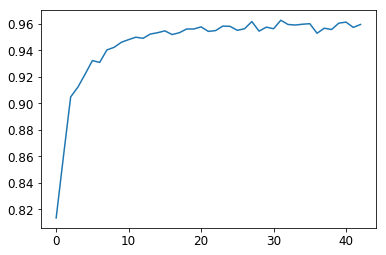

In [17]:
plt.plot(clf.validation_scores_)
plt.show()

Because we used early stopping, we do not expect ovefitting. To save a bit time, we will skip `cross_val_score` and calculate the accuracy on the test dataset.

In [18]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9595

It is about the same value shown in the graph, another proof the network is not overfitting.

The validation graph shows that the accuracy is bouncing around somewhat. This is an indication that the classifier is not finding the local minimum, just going around it over and over.

As a last attempt to squeeze a bit more accuracy from the classifier, we will use an adaptive learning rate, because [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.fit) says "_Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early&#95;stopping’ is on, the current learning rate is divided by 5._"


In [19]:
%%time

clf = MLPClassifier(hidden_layer_sizes=(100,), 
                    learning_rate="adaptive",  # <----- this is new, everything else is the same
                    learning_rate_init=0.001, max_iter=500, early_stopping=True, tol=1e-4, n_iter_no_change=10, 
                    activation="relu", solver="adam", alpha=0.0001, batch_size=100, random_state=42)
fit_results = clf.fit(X_train, y_train)

print(fit_results)  # must explicitly print because of %%time

MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
CPU times: user 3min 7s, sys: 23.4 s, total: 3min 31s
Wall time: 57.2 s


Plot the validation accuracy during training to see how many epochs it needed and how it behaved along the way.

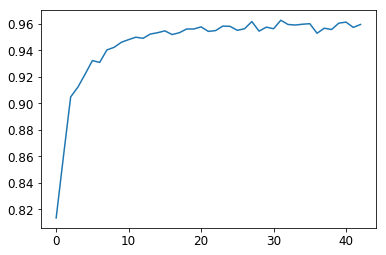

In [20]:
plt.plot(clf.validation_scores_)
plt.show()

In [21]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9595

Same result. This seems to the most we can extract from this network.

# Step 5: Network architecture changes

This step is not so much a "optimization" step, as it is a change of direction.

The network used in the previous step seems to have reached its limits of representation.

In this step we will attempt to give the network more representation power using grid search to test:

- Adding more neurons to the layer
- Adding more layers

We will use `GridSearchCV` to try different network architectures.

In [22]:
%%time

from sklearn.model_selection import GridSearchCV

# The base network
base_clf = MLPClassifier(learning_rate="adaptive", learning_rate_init=0.001, max_iter=500, early_stopping=True,
                    tol=1e-4, n_iter_no_change=10, activation="relu", solver="adam", alpha=0.0001, batch_size=100,
                    random_state=42)

# The parameters for the grid search: layers
layers_to_try = { "hidden_layer_sizes": [(500), (100,100)] }

gs = GridSearchCV(base_clf, layers_to_try, n_jobs=-1, cv=3, verbose=50, return_train_score=True)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  4.0min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  4.1min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  5.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.4min finished
CPU times: user 13min 52s, sys: 1min 27s, total: 15min 19s
Wall time: 10min 21s


## Analyze the best classifier

Show the best classifier and save it for the next cells

In [23]:
print("Best network structure:", gs.best_params_)

clf = gs.best_estimator_
print(clf)

Best network structure: {'hidden_layer_sizes': 500}
MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=500, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


We don't have to run `cross_val_score` here because it has already been cross-validated during grid search.

In [24]:
print(gs.cv_results_["mean_test_score"][gs.best_index_])

0.96898


Accuracy on the test dataset.

In [25]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9729

There are no signs of overfitting in this case.

Plot the validation accuracy during training to see how many epochs it needed and how it behaved along the way.

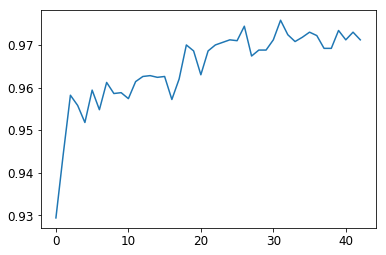

In [26]:
plt.plot(clf.validation_scores_)
plt.show()

After going through this analysis, let's check all classifiers in the grid search.

In [27]:
print(gs.cv_results_["mean_test_score"])

[0.96898 0.96192]


The classifiers are very close to each other. From this point on, other interesting tests would to either continue in this direction (add more layers, add more neurons in hidden layers), or change the hyperparameters of the best network work we got so far (e.g. change beta1 and beta2 for the Adam classifier, or go back to the SGD classifier and try combinations of learning rates and momentum).

For this experiment we will stop here and analyze the best network in more deatils.

# Step 6: Analysis of the best network

## Confusion matrix

Confusion matrix reminder: rows are the actual classes and columns are predicted classes.

In [28]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

[[ 963    1    4    3    0    3    3    2    1    0]
 [   0 1124    2    3    0    2    0    1    3    0]
 [   1    3 1005    7    2    1    2    7    4    0]
 [   0    0    2  986    0   10    0    3    7    2]
 [   0    1    4    0  947    0    7    3    4   16]
 [   1    0    0   12    1  863    2    3    6    4]
 [   2    3    1    1    1   10  935    1    4    0]
 [   1    4   13    5    0    0    0  997    2    6]
 [   0    1    4    9    4    4    2    3  944    3]
 [   1    4    0    6   10    6    1    8    8  965]]


In graphical format, where lighter color = highest error rate.

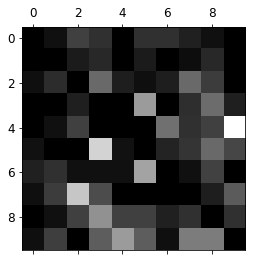

In [39]:
# Adapted from Géron's notebooks 

# Normalize each row so one class doesn't dominate the values, skewing the heatmap
# This is not strictly necessary in this case because MNIST classes are well-balanced
# It's good practice nevertheless
row_sums = conf_mx.sum(axis=1, keepdims=True)
conf_mx_misclassifications = conf_mx / row_sums

# Remove correct classifications (leaves only misclassifications in the matrix)
np.fill_diagonal(conf_mx_misclassifications, 0)  

plt.matshow(conf_mx_misclassifications, cmap=plt.cm.gray)
plt.show()

The heatmap shows these high error rates:

- 4s being classified as 9
- 5s being classified as 3
- 7s being classified as 2

## Misclassifed digits

This section shows the image of misclassified digits and correctly classified digits.

**NOTE**: since we are working with the test dataset here, we will not always have enough misclassified digits to fill the rows and columns. The classifier has a pretty high accuracy. (We always have enough correctly classified digits, though).

Each plot below will show a sample of the misclassied classes in this format:

|Classifed as A|Classified as B|
|----|----|
| As correctly classified as As | As incorrecly classified as Bs |
| Bs incorrectly classified as Bs | Bs correctly classified as Bs |


First we define some auxliary functions.

In [40]:
# Adapted from Géron's notebooks 

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [31]:
def plot_classes(cl_a, cl_b):
    
    # All cl_a digits that are correctly classified (predicted)
    X_aa = X_test[(y_test == cl_a) & (y_pred == cl_a)]

    # All cl_a digits that are mistakenly classified as cl_b
    X_ab = X_test[(y_test == cl_a) & (y_pred == cl_b)]

    # All cl_b digits mistakenly classified as cl_a
    X_ba = X_test[(y_test == cl_b) & (y_pred == cl_a)]

    # All cl_b digits that are correctly classified
    X_bb = X_test[(y_test == cl_b) & (y_pred == cl_b)]
    
    plt.figure(figsize=(8,8))
    plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
    plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
    plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
    plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
    plt.show()

### 4s classified as 9 and vice-versa

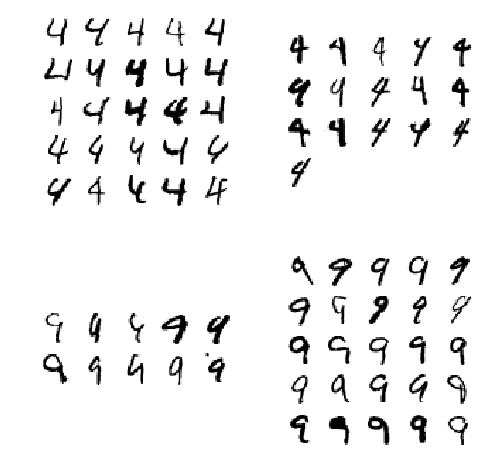

In [32]:
plot_classes(4, 9)

### 5s classified as 3 and vice-versa

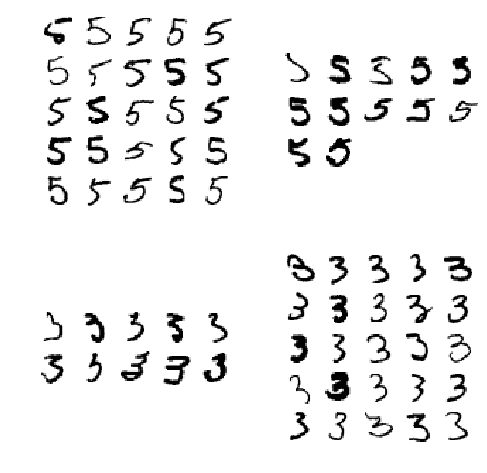

In [33]:
plot_classes(5, 3)

### 7s classified as 2 and vice-versa

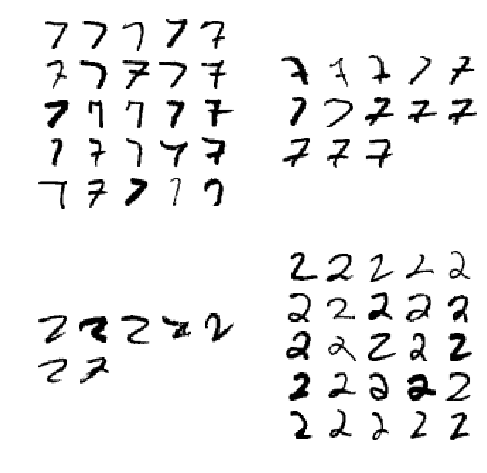

In [34]:
plot_classes(7, 2)

## Visualization of the first hidden layer

As an exercise for my own education, this section visualizes the weights in the first hidden layer of the network (and the only hidden layer in this case).

The goal is to understand what the neurons are "learning" about the input data, if anything.

The first hidden layer has 500 neurons and is connected to the input layer, which in this case has 784 features, one for each pixel of the image. Therefore the shape of the weight matrix for this layer is (784, 500). 

For this layer we can represent the input in each neuron as an image of 28x28, the shape of the input image.

In [35]:
# Adapted from https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html

def plot_weights(weights, rows, columns, figsize, reshape=(28, 28)):
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    # use global min / max to ensure all weights are shown on the same scale
    vmin, vmax = weights.min(), weights.max()
    for w, ax in zip(weights.T, axes.ravel()):
        ax.imshow(w.reshape(reshape), cmap=plt.cm.gray, vmin=0.3 * vmin,
                  vmax=0.3 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())
        
    # Add rows and column numbers for orientation
    # Adapted from https://stackoverflow.com/a/25814386
    for ax, c in zip(axes[0], range(columns)):
        ax.set_title(c)
    for ax, r in zip(axes[:,0], range(rows)):
        ax.set_ylabel(r, rotation=0)
    
    plt.show()

In [36]:
clf = gs.best_estimator_
print(clf.coefs_[0].shape)

(784, 500)


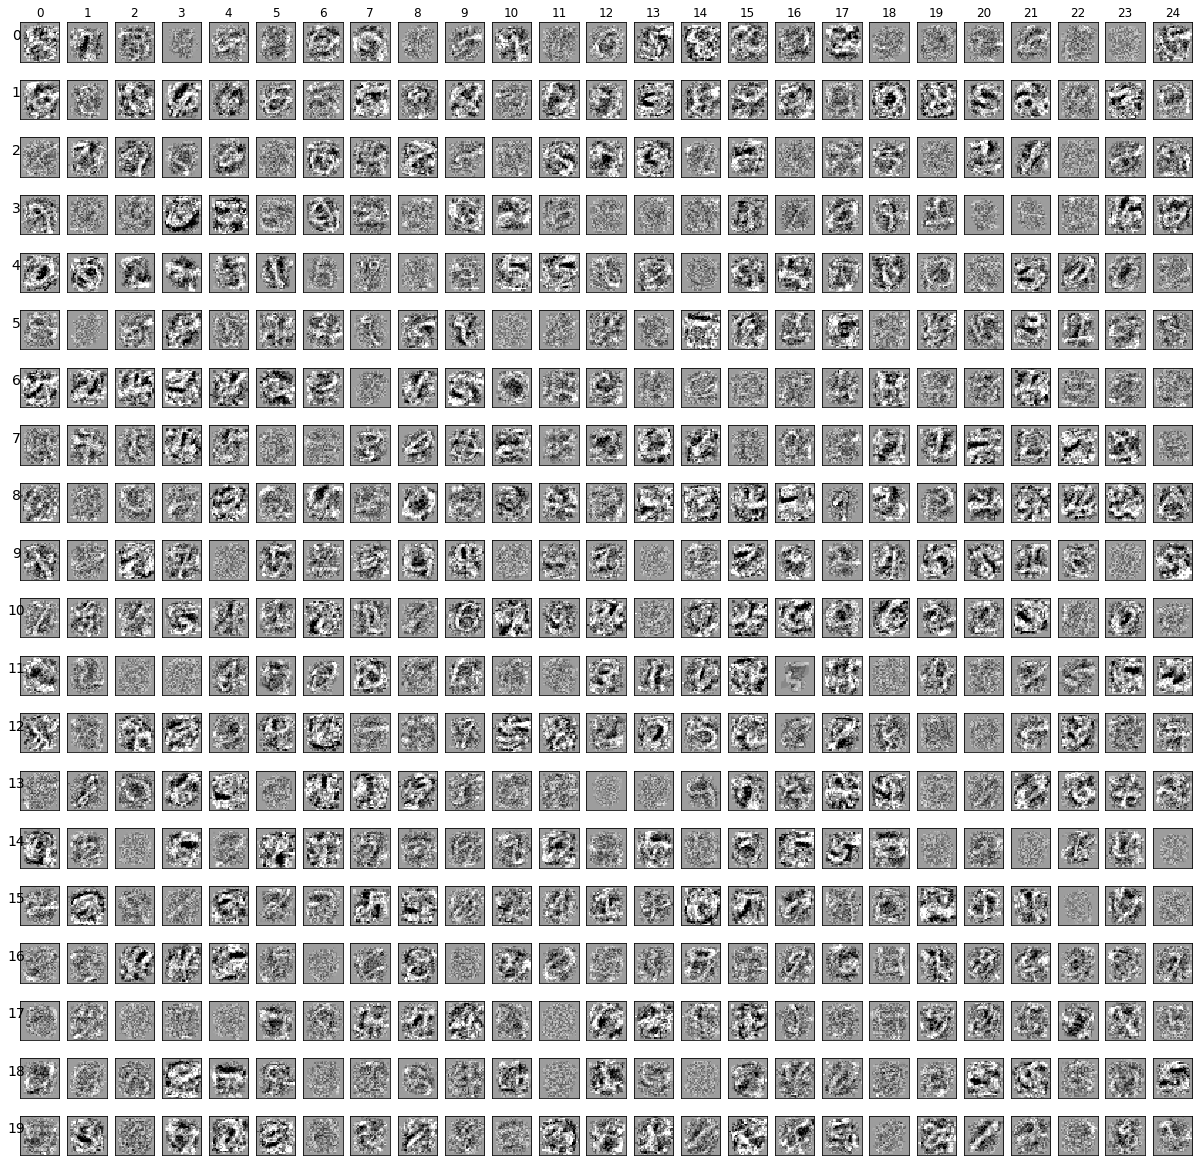

In [37]:
plot_weights(clf.coefs_[0], 20, 25, (21, 21))

Because we have only one layer, most neurons seem to be identifying patterns that are highly correlated to the digits themselves, as opposed to higher-level patterns (such as "a circle in the bottom half", that could discriminate 8s from 9s).

Other neurons are not identifying any distinguisable pattern, alomost

Future investigations:
    
- Do the neurons wihtout a pattern are just noise? In other words, could we reduce the number of neurons in this layer by the number of "noisy" ones and still get the same performance?
- How to visualize the weights in other layers (other hidden layers, if we had more, and the output layer)? The input layer shape matches the input data shape, lending itself to being represented as a 28x28 image. What if we had second hidden layer with 100 neurons? Should we depict it as a 10x10 image or something else?